Importing libraries and datasets

In [ ]:
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize

df = pd.read_csv('/content/financial_sentiment_merged.csv')

with open('/content/vocabulary.json', 'r') as f:
    vocab = json.load(f)

fasttext_embeddings = np.load('/content/fasttext_embeddings.npy')
word2vec_embeddings = np.load('/content/word2vec_embeddings.npy')
print("Dataset shape:", df.shape)
print("Vocabulary size:", len(vocab))
print("FastText Embeddings shape:", fasttext_embeddings.shape)
print("Word2Vec Embeddings shape:", word2vec_embeddings.shape)


Looking in indexes: https://download.pytorch.org/whl/cu118
Dataset shape: (43933, 3)
Vocabulary size: 2
FastText Embeddings shape: (48945, 100)
Word2Vec Embeddings shape: (48945, 100)


Analysis of embeddings

Filtered FastText shape: (48945, 100)
Filtered Word2Vec shape: (48945, 100)
Missing words from embeddings: 0

FastText norms: mean = 3.6006203424752563 , std = 1.4854627389417725
Word2Vec norms: mean = 10.0970745 , std = 0.75594795

Top similar words to 'market' in FastText:
['.market', '@market', '-market', 'vmarket', 'smarket']
Top similar words to 'market' in Word2Vec:
['clx', 'sp500', 'infuse', '390c', 'hietanen']


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


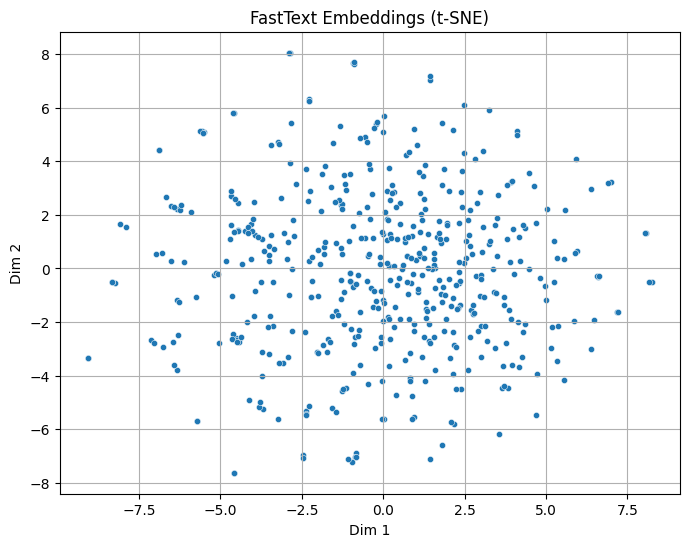

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


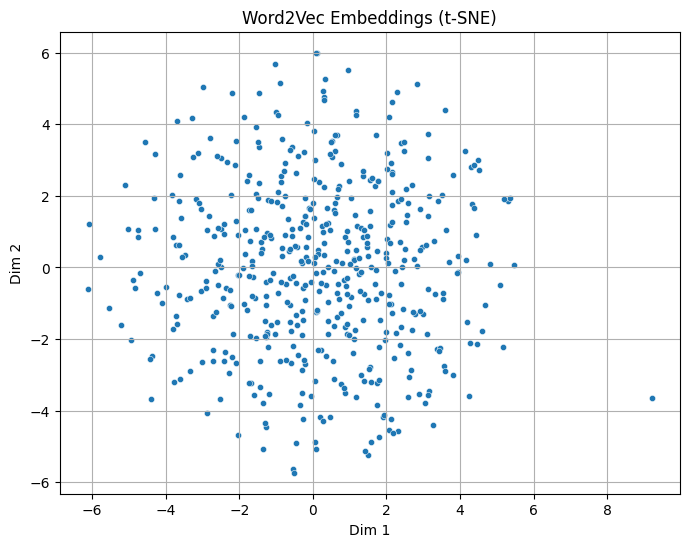

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import numpy.linalg as LA

# === Filter Embeddings Based on Vocabulary Indexes ===
new_fasttext = []
new_word2vec = []
valid_vocab = {}   # Keep track of valid words and their new indices
missing_words = []

# Access the 'word2idx' dictionary inside 'vocab'
for word, idx in vocab['word2idx'].items():  # Change here
    if idx < fasttext_embeddings.shape[0]:
        new_fasttext.append(fasttext_embeddings[idx])
        new_word2vec.append(word2vec_embeddings[idx])
        valid_vocab[word] = len(new_fasttext) - 1
    else:
        missing_words.append(word)

fasttext_embeddings_filtered = np.array(new_fasttext)
word2vec_embeddings_filtered = np.array(new_word2vec)

print("Filtered FastText shape:", fasttext_embeddings_filtered.shape)
print("Filtered Word2Vec shape:", word2vec_embeddings_filtered.shape)
print("Missing words from embeddings:", len(missing_words))

# === Norm Analysis ===
fasttext_norms = LA.norm(fasttext_embeddings_filtered, axis=1)
word2vec_norms = LA.norm(word2vec_embeddings_filtered, axis=1)

print("\nFastText norms: mean =", np.mean(fasttext_norms), ", std =", np.std(fasttext_norms))
print("Word2Vec norms: mean =", np.mean(word2vec_norms), ", std =", np.std(word2vec_norms))

# === Cosine Similarity Check ===
def get_similar_words(word, embeddings, vocab_dict):
    if word not in vocab_dict:
        print(f"'{word}' not found in vocabulary.")
        return []
    idx = vocab_dict[word]
    if idx >= len(embeddings):
        print(f"'{word}' index {idx} is out of bounds.")
        return []

    similarities = cosine_similarity([embeddings[idx]], embeddings)[0]
    top_indices = np.argsort(similarities)[-6:-1][::-1]

    inv_vocab = {i: w for w, i in vocab_dict.items()}
    return [inv_vocab.get(i, f"<UNK_{i}>") for i in top_indices]

# Try a word known to be present
sample_word = 'market'
print(f"\nTop similar words to '{sample_word}' in FastText:")
print(get_similar_words(sample_word, fasttext_embeddings_filtered, valid_vocab))

print(f"Top similar words to '{sample_word}' in Word2Vec:")
print(get_similar_words(sample_word, word2vec_embeddings_filtered, valid_vocab))

# === t-SNE Visualization ===
def tsne_plot(embeddings, title):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    reduced = tsne.fit_transform(embeddings[:500])
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], s=20)
    plt.title(f'{title} (t-SNE)')
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.grid(True)
    plt.show()

# Optional: visualize
tsne_plot(fasttext_embeddings_filtered, "FastText Embeddings")
tsne_plot(word2vec_embeddings_filtered, "Word2Vec Embeddings")

Average similariity between two embeddings

In [ ]:
# # === Avg Similarity Calculation ===
# def avg_cosine_sim(embeddings):
#     sim_matrix = cosine_similarity(embeddings)
#     np.fill_diagonal(sim_matrix, 0)
#     return sim_matrix.mean(axis=1)

# fast_avg = avg_cosine_sim(fasttext_embeddings_filtered)
# w2v_avg = avg_cosine_sim(word2vec_embeddings_filtered)

# print("FastText Avg Cosine Sim: mean =", fast_avg.mean(), ", std =", fast_avg.std())
# print("Word2Vec Avg Cosine Sim: mean =", w2v_avg.mean(), ", std =", w2v_avg.std())

# # === Plot Comparison ===
# plt.figure(figsize=(8, 4))
# sns.kdeplot(fast_avg, label='FastText', fill=True)
# sns.kdeplot(w2v_avg, label='Word2Vec', fill=True)
# plt.title("Avg Cosine Similarity per Word")
# plt.xlabel("Similarity")
# plt.legend()
# plt.grid(True)
# plt.show()


SetUp

In [ ]:
#Preprocess inputs for models
nltk.download('punkt')

def tokenize_and_vectorize(df, embeddings, vocab_dict, max_len=50):
    vectors = []
    for text in tqdm(df['Cleaned']):
        tokens = word_tokenize(str(text).lower())
        vec = []
        for tok in tokens[:max_len]:
            idx = vocab_dict.get(tok, None)
            if idx is not None and idx < embeddings.shape[0]:
                vec.append(embeddings[idx])
        if len(vec) < max_len:
            vec.extend([np.zeros(embeddings.shape[1])] * (max_len - len(vec)))
        vectors.append(np.array(vec))
    return np.array(vectors)


#Label encoding
le = LabelEncoder()
y = le.fit_transform(df['Sentiment'])

X_train_text, X_test_text, y_train, y_test = train_test_split(df['Cleaned'], y, test_size=0.2, random_state=42)

train_df = pd.DataFrame({'Cleaned': X_train_text})
test_df = pd.DataFrame({'Cleaned': X_test_text})



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Model -1 : Logistic Regression with Averaged Embeddings

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from tqdm import tqdm
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt_tab')

evaluation_results = {
    'FastText': {
        'LogisticRegression': {'accuracy': None, 'report': None},
        'RandomForest': {'accuracy': None, 'report': None},  # Add 'RandomForest' here
        'CNN': {'accuracy': None, 'report': None}  # Add 'CNN' here
    },
    'Word2Vec': {
        'LogisticRegression': {'accuracy': None, 'report': None},
        'RandomForest': {'accuracy': None, 'report': None},  # Add 'RandomForest' here
        'CNN': {'accuracy': None, 'report': None}  # Add 'CNN' here
    }
}


# Store evaluation results function
def store_results(embedding_type, model_name, accuracy, classification_rep):
    evaluation_results[embedding_type][model_name]['accuracy'] = accuracy
    evaluation_results[embedding_type][model_name]['report'] = classification_rep

# Average embeddings function
def average_embeddings(df_texts, embeddings, vocab_dict):
    averaged = []
    for text in tqdm(df_texts):
        tokens = word_tokenize(str(text).lower())
        vecs = [embeddings[vocab_dict[tok]] for tok in tokens if tok in vocab_dict]
        if vecs:
            avg = np.mean(vecs, axis=0)
        else:
            avg = np.zeros(embeddings.shape[1])
        averaged.append(avg)
    return np.array(averaged)

# FastText embeddings
X_train_ft = average_embeddings(X_train_text, fasttext_embeddings_filtered, valid_vocab)
X_test_ft  = average_embeddings(X_test_text, fasttext_embeddings_filtered, valid_vocab)

# Word2Vec embeddings
X_train_w2v = average_embeddings(X_train_text, word2vec_embeddings_filtered, valid_vocab)
X_test_w2v  = average_embeddings(X_test_text, word2vec_embeddings_filtered, valid_vocab)

# Logistic Regression function with storing results
def run_logistic_regression(X_train, y_train, X_test, y_test, name=""):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le.classes_.astype(str), output_dict=True)

    evaluation_results[name]["LogisticRegression"]['accuracy'] = acc
    evaluation_results[name]["LogisticRegression"]['report'] = report


    print(f"\n=== Logistic Regression ({name}) ===")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred, target_names=le.classes_.astype(str)))


# Run Logistic Regression for FastText and Word2Vec
run_logistic_regression(X_train_ft, y_train, X_test_ft, y_test, "FastText")
run_logistic_regression(X_train_w2v, y_train, X_test_w2v, y_test, "Word2Vec")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
100%|██████████| 8787/8787 [00:01<00:00, 4919.69it/s]



=== Logistic Regression (FastText) ===
Accuracy: 0.5667463298053943
              precision    recall  f1-score   support

          -1       0.55      0.54      0.55      2610
           0       0.59      0.74      0.66      4101
           1       0.48      0.25      0.33      2076

    accuracy                           0.57      8787
   macro avg       0.54      0.51      0.51      8787
weighted avg       0.55      0.57      0.55      8787


=== Logistic Regression (Word2Vec) ===
Accuracy: 0.5604870831910778
              precision    recall  f1-score   support

          -1       0.55      0.52      0.54      2610
           0       0.58      0.77      0.66      4101
           1       0.47      0.19      0.27      2076

    accuracy                           0.56      8787
   macro avg       0.53      0.50      0.49      8787
weighted avg       0.54      0.56      0.53      8787



## Model - 2 : Random Forest with Averaged Embeddings

In [ ]:
def run_random_forest(X_train, y_train, X_test, y_test, name=""):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le.classes_.astype(str), output_dict=True)


    evaluation_results[name]["RandomForest"]['accuracy'] = acc
    evaluation_results[name]["RandomForest"]['report'] = report

    print(f"\n=== Random Forest ({name}) ===")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred, target_names=le.classes_.astype(str)))


run_random_forest(X_train_ft, y_train, X_test_ft, y_test, "FastText")
run_random_forest(X_train_w2v, y_train, X_test_w2v, y_test, "Word2Vec")



=== Random Forest (FastText) ===
Accuracy: 0.6090815978149539
              precision    recall  f1-score   support

          -1       0.61      0.62      0.62      2610
           0       0.62      0.79      0.69      4101
           1       0.55      0.24      0.33      2076

    accuracy                           0.61      8787
   macro avg       0.59      0.55      0.55      8787
weighted avg       0.60      0.61      0.59      8787


=== Random Forest (Word2Vec) ===
Accuracy: 0.5860930920678274
              precision    recall  f1-score   support

          -1       0.61      0.55      0.58      2610
           0       0.58      0.82      0.68      4101
           1       0.52      0.16      0.24      2076

    accuracy                           0.59      8787
   macro avg       0.57      0.51      0.50      8787
weighted avg       0.58      0.59      0.55      8787



## Model -3 : CNN

### Define Dataset

In [ ]:
import torch.nn as nn


class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes, num_filters=100, kernel_sizes=[3, 4, 5]):
        super(CNNModel, self).__init__()
        self.convs = nn.ModuleList([
            nn.Conv1d(input_dim, num_filters, k) for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)

    def forward(self, x):
        # x needs to have dimensions (batch_size, embedding_dim, sequence_length)
        x = x.permute(0, 2, 1)
        x = [torch.relu(conv(x)) for conv in self.convs]
        x = [torch.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x
class TextDataset(Dataset):
    def __init__(self, texts, labels, embeddings, vocab_dict, max_len=50):
        self.max_len = max_len
        self.embeddings = embeddings
        self.vocab_dict = vocab_dict
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, sample_idx): # Changed idx to sample_idx
        tokens = word_tokenize(str(self.texts[sample_idx]).lower()) # Use sample_idx
        vecs = []
        for tok in tokens[:self.max_len]:
            tok_idx = self.vocab_dict.get(tok, None) # Changed idx to tok_idx
            if tok_idx is not None and tok_idx < self.embeddings.shape[0]:
                vecs.append(self.embeddings[tok_idx]) # Use tok_idx
        if len(vecs) < self.max_len:
            vecs.extend([np.zeros(self.embeddings.shape[1])] * (self.max_len - len(vecs)))
        vecs = np.array(vecs, dtype=np.float32)
        return torch.tensor(vecs), torch.tensor(self.labels[sample_idx], dtype=torch.long) # Use sample_idx

# Update the CNN training and evaluation function
def train_and_evaluate_cnn(texts_train, texts_test, y_train, y_test, embeddings, name):
    train_dataset = TextDataset(texts_train, y_train, embeddings, valid_vocab)
    test_dataset = TextDataset(texts_test, y_test, embeddings, valid_vocab)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    model = CNNModel(input_dim=embeddings.shape[1], num_classes=len(np.unique(y_train)))
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model.train()
    print(f"\nTraining CNN model ({name})...")
    for epoch in range(5):
        total_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        for X_batch, y_batch in loop:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())
        print(f"Epoch {epoch+1}: Total Loss = {total_loss:.4f}")

    model.eval()
    y_true, y_pred = [], []
    print("Evaluating on test set...")
    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader, desc="Testing"):
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(y_batch.tolist())
            y_pred.extend(preds.tolist())

    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=le.classes_.astype(str))

    # Store the evaluation results
    evaluation_results[name]["CNN"]['accuracy'] = accuracy
    evaluation_results[name]["CNN"]['report'] = report

    print(f"\n=== CNN ({name}) ===")
    print("Accuracy:", accuracy)
    print(report)


train_and_evaluate_cnn(X_train_text.tolist(), X_test_text.tolist(), y_train, y_test, fasttext_embeddings_filtered, "FastText")
train_and_evaluate_cnn(X_train_text.tolist(), X_test_text.tolist(), y_train, y_test, word2vec_embeddings_filtered, "Word2Vec")





Training CNN model (FastText)...


Epoch 1: 100%|██████████| 1099/1099 [00:44<00:00, 24.64it/s, loss=1.11]


Epoch 1: Total Loss = 1002.4459


Epoch 2: 100%|██████████| 1099/1099 [00:43<00:00, 25.53it/s, loss=0.936]


Epoch 2: Total Loss = 936.6729


Epoch 3: 100%|██████████| 1099/1099 [00:46<00:00, 23.46it/s, loss=0.917]


Epoch 3: Total Loss = 891.5641


Epoch 4: 100%|██████████| 1099/1099 [00:43<00:00, 25.22it/s, loss=0.748]


Epoch 4: Total Loss = 866.3101


Epoch 5: 100%|██████████| 1099/1099 [00:42<00:00, 25.75it/s, loss=0.912]


Epoch 5: Total Loss = 836.5219
Evaluating on test set...


Testing: 100%|██████████| 275/275 [00:04<00:00, 58.88it/s]



=== CNN (FastText) ===
Accuracy: 0.6245590076249005
              precision    recall  f1-score   support

          -1       0.57      0.70      0.63      2610
           0       0.67      0.74      0.70      4101
           1       0.60      0.30      0.40      2076

    accuracy                           0.62      8787
   macro avg       0.61      0.58      0.58      8787
weighted avg       0.62      0.62      0.61      8787


Training CNN model (Word2Vec)...


Epoch 1: 100%|██████████| 1099/1099 [00:43<00:00, 25.24it/s, loss=0.819]


Epoch 1: Total Loss = 1022.7733


Epoch 2: 100%|██████████| 1099/1099 [00:42<00:00, 25.80it/s, loss=0.944]


Epoch 2: Total Loss = 913.6532


Epoch 3: 100%|██████████| 1099/1099 [00:42<00:00, 25.58it/s, loss=0.456]


Epoch 3: Total Loss = 842.4967


Epoch 4: 100%|██████████| 1099/1099 [00:44<00:00, 24.88it/s, loss=0.897]


Epoch 4: Total Loss = 785.7416


Epoch 5: 100%|██████████| 1099/1099 [00:43<00:00, 25.22it/s, loss=0.652]


Epoch 5: Total Loss = 735.6978
Evaluating on test set...


Testing: 100%|██████████| 275/275 [00:04<00:00, 57.55it/s]


=== CNN (Word2Vec) ===
Accuracy: 0.6243313986571071
              precision    recall  f1-score   support

          -1       0.58      0.67      0.63      2610
           0       0.67      0.72      0.70      4101
           1       0.55      0.38      0.45      2076

    accuracy                           0.62      8787
   macro avg       0.60      0.59      0.59      8787
weighted avg       0.62      0.62      0.62      8787



Analaysis and evaluation

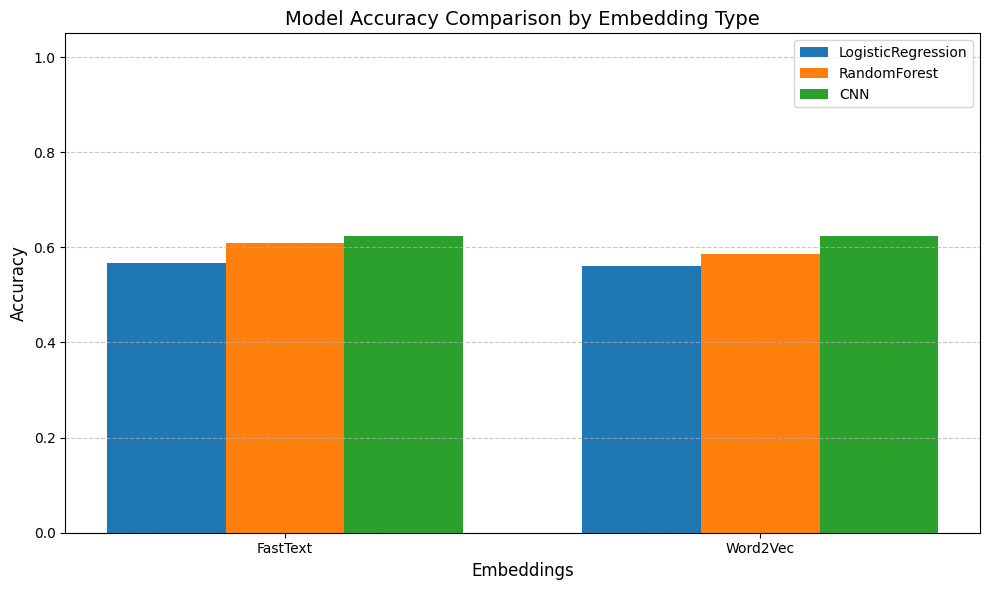


=== Accuracy Summary ===

--- FastText ---
LogisticRegression  : 0.5667463298053943
RandomForest        : 0.6090815978149539
CNN                 : 0.6245590076249005

--- Word2Vec ---
LogisticRegression  : 0.5604870831910778
RandomForest        : 0.5860930920678274
CNN                 : 0.6243313986571071


In [ ]:
import matplotlib.pyplot as plt

# Extract model names and embedding types
models = ['LogisticRegression', 'RandomForest', 'CNN']
embeddings = ['FastText', 'Word2Vec']

# Collect accuracy data, handling None values
accuracy_data = {
    model: [
        evaluation_results.get(embed, {}).get(model, {}).get('accuracy') # Use get method to avoid KeyError
        if evaluation_results.get(embed, {}).get(model, {}).get('accuracy') is not None
        else 0  # Replace None with 0 for plotting
        for embed in embeddings
    ]
    for model in models
}

# Plot
x = range(len(embeddings))  # indices for embeddings
bar_width = 0.25

plt.figure(figsize=(10, 6))

# Plot each model's bar
for i, model in enumerate(models):
    plt.bar([pos + i * bar_width for pos in x], accuracy_data[model], width=bar_width, label=model)

# Axis settings
plt.xlabel('Embeddings', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Accuracy Comparison by Embedding Type', fontsize=14)
plt.xticks([pos + bar_width for pos in x], embeddings)
plt.ylim(0, 1.05)  # accuracy range from 0 to 1
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



print("\n=== Accuracy Summary ===")
for embed in embeddings:
    print(f"\n--- {embed} ---")
    for model in models:
        acc = evaluation_results.get(embed, {}).get(model, {}).get('accuracy') # Use get method to avoid KeyError
        print(f"{model:20}: {acc if acc is not None else 'N/A'}")  # Change here